# Laboratorium 5 - Kacper Dudczak


Plik gratkapl-centrenrm.csv zawiera dane wzbogacone o nową cechę Centre, przyjmującą wartość 1, jeżeli lokalizacja mieszkania to centrum, i 0 w przeciwnym przypadku.

## 5. Zamiast przywidywania ceny mieszkania, spróbuj przewidzieć lokalizację mieszkania: centrum vs. nie-centrum za pomocą regresji logistcznej.

- [X] Podziel dane trenujące na nowe dane treningowe (pierwsze 4/5 danych) i testowe (ostatnie 1/5 danych)
- [X] Stwórz dwuklasowy model regresji logistycznej, korzystając z cech liczbowych Price,Rooms,SqrMeters,Floor. 
    - [X] Warto usunąć obserwacje odstające i dokonać normalizacji danych.
- [ ] Podaj procent poprawnych wyników (tzw. skuteczność, accuracy) dla zestawu testowego.
- [ ] Otrzymaną wartość porównaj z wynikiem uzyskiwanym przez klasyfikator losowy (czyli taki, który przyporządkowuje losową wartość 0 lub 1 z prawdopodobieństem 1/2).


*Uwaga: Cecha Centre została wygenerowana automatycznie na podstawie opisów lokalizacji mieszkań i okazuje się, że jest słabo skorelowana z cechami liczbowymi, dlatego proszę się nie przejmować, jeżeli wartości funkcji regresji logistycznej i przewidywania modelu będą nieco dziwne.*

In [11]:
# Przydatne importy

import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import pandas as pd
import ipywidgets as widgets

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.display import display, Math, Latex

In [25]:
# Przydatne funkcje

# Wyświetlanie macierzy w LaTeX-u
def LatexMatrix(matrix):
    ltx = r'\left[\begin{array}'
    m, n = matrix.shape
    ltx += '{' + ("r" * n) + '}'
    for i in range(m):
        ltx += r" & ".join([('%.4f' % j.item()) for j in matrix[i]]) + r" \\ "
    ltx += r'\end{array}\right]'
    return ltx

# Hipoteza (wersja macierzowa)
def hMx(theta, X):
    return X * theta

# Wykres danych (wersja macierzowa)
def regdotsMx(X, y, xlabel, ylabel):    
    fig = pl.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter([X[:, 1]], [y], c='r', s=50, label='Dane')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(.05, .05)
    pl.ylim(y.min() - 1, y.max() + 1)
    pl.xlim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
    return fig

# Wykres krzywej regresji (wersja macierzowa)
def reglineMx(fig, fun, theta, X):
    ax = fig.axes[0]
    x0 = np.min(X[:, 1]) - 1.0
    x1 = np.max(X[:, 1]) + 1.0
    L = [x0, x1]
    LX = np.matrix([1, x0, 1, x1]).reshape(2, 2)
    ax.plot(L, fun(theta, LX), linewidth='2',
            label=(r'$y={theta0:.2}{op}{theta1:.2}x$'.format(
                theta0=float(theta[0][0]),
                theta1=(float(theta[1][0]) if theta[1][0] >= 0 else float(-theta[1][0])),
                op='+' if theta[1][0] >= 0 else '-')))

# Legenda wykresu
def legend(fig):
    ax = fig.axes[0]
    handles, labels = ax.get_legend_handles_labels()
    # try-except block is a fix for a bug in Poly3DCollection
    try:
        fig.legend(handles, labels, fontsize='15', loc='lower right')
    except AttributeError:
        pass

# Wersja macierzowa funkcji kosztu
def JMx(theta,X,y):
    m = len(y)
    J = 1.0 / (2.0 * m) * ((X * theta - y).T * ( X * theta - y))
    return J.item()

# Wersja macierzowa gradientu funkcji kosztu
def dJMx(theta,X,y):
    return 1.0 / len(y) * (X.T * (X * theta - y)) 

# Implementacja algorytmu gradientu prostego za pomocą numpy i macierzy
def GDMx(fJ, fdJ, theta, X, y, alpha=0.1, eps=10**-3):
    current_cost = fJ(theta, X, y)
    logs = [[current_cost, theta]]
    while True:
        theta = theta - alpha * fdJ(theta, X, y) # implementacja wzoru
        current_cost, prev_cost = fJ(theta, X, y), current_cost
        if current_cost > 10000:
            break
        if abs(prev_cost - current_cost) <= eps:
            break
        logs.append([current_cost, theta]) 
    return theta, logs

thetaStartMx = np.matrix([0, 0]).reshape(2, 1)

# Funkcja, która rysuje próg
def threshold(fig, theta):
    x_thr = (0.5 - theta.item(0)) / theta.item(1)
    ax = fig.axes[0]
    ax.plot([x_thr, x_thr], [-1, 2],
            color='orange', linestyle='dashed',
            label=u'próg: $x={:.2F}$'.format(x_thr))

In [31]:
# Wczytanie danych

data_gratka = pandas.read_csv('gratkapl-centrenrm.csv', usecols = ["Price", "Rooms", "SqrMeters", "Floor", "Centre"])

In [32]:
# Podzial tablicy na  5 czesci, 4 do trenowania i 1 do testowania

split_array = np.array_split(data_gratka, 5)

training_data = pd.concat(split_array[:4])

test_data = split_array[4]

In [38]:
# Przygotowanie danych

m, n_plus_1 = training_data.values.shape
n = n_plus_1 - 1
Xn = training_data.values[:, 0:n].reshape(m, n)

XMx4 = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
yMx4 = np.matrix(training_data.values[:, n]).reshape(m, 1)

print(XMx4[:6])
print(yMx4[:6])

[[1.00000e+00 3.86064e+05 2.00000e+00 4.60000e+01 3.00000e+00]
 [1.00000e+00 2.80000e+05 2.00000e+00 4.10000e+01 5.00000e+00]
 [1.00000e+00 3.29000e+05 2.00000e+00 5.05000e+01 1.00000e+00]
 [1.00000e+00 2.25000e+05 2.00000e+00 4.30000e+01 1.00000e+01]
 [1.00000e+00 2.80000e+05 2.00000e+00 6.90000e+01 3.00000e+00]
 [1.00000e+00 2.73000e+05 3.00000e+00 7.90000e+01 1.40000e+01]]
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [39]:
# Przygotowanie danych

m2, n2_plus_1 = test_data.values.shape
n2 = n2_plus_1 - 1
Xn2 = test_data.values[:, 0:n2].reshape(m2, n2)

XMx4_2 = np.matrix(np.concatenate((np.ones((m2, 1)), Xn2), axis=1)).reshape(m2, n2_plus_1)
yMx4_2 = np.matrix(test_data.values[:, n2]).reshape(m2, 1)

print(XMx4_2[:6])
print(yMx4_2[:6])

[[1.0000e+00 6.9000e+05 2.0000e+00 1.2100e+02 1.0000e+00]
 [1.0000e+00 1.9755e+05 2.0000e+00 4.9400e+01 2.0000e+00]
 [1.0000e+00 3.3000e+05 4.0000e+00 7.4500e+01 1.0000e+00]
 [1.0000e+00 1.1400e+06 6.0000e+00 1.9240e+02 1.0000e+00]
 [1.0000e+00 1.9400e+05 1.0000e+00 3.6100e+01 1.0000e+00]
 [1.0000e+00 1.7200e+05 1.0000e+00 3.0000e+01 8.0000e+00]]
[[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [40]:
# Funkcja, która pokazuje wartości minimalne i maksymalne w macierzy X

def show_mins_and_maxs(XMx):
    mins = np.amin(XMx, axis=0).tolist()[0]  # wartości minimalne
    maxs = np.amax(XMx, axis=0).tolist()[0]  # wartości maksymalne
    for i, (xmin, xmax) in enumerate(zip(mins, maxs)):
        display(Math(
            r'${:.2F} \leq x_{} \leq {:.2F}$'.format(xmin, i, xmax)))

In [48]:
print("Trening")
show_mins_and_maxs(XMx4)

print("\nTest")
show_mins_and_maxs(XMx4_2)

Trening


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Test


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [49]:
print("Trening")
XMx4_scaled = XMx4 / np.amax(XMx4, axis=0)
show_mins_and_maxs(XMx4_scaled)

print("\nTest")
XMx4_2_scaled = XMx4_2 / np.amax(XMx4_2, axis=0)
show_mins_and_maxs(XMx4_2_scaled)

Trening


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Test


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [50]:
print("Trening")
XMx4_norm = (XMx4 - np.mean(XMx4, axis=0)) / np.amax(XMx4, axis=0)
show_mins_and_maxs(XMx4_norm)

print("\nTest")
XMx4_2_norm = (XMx4_2 - np.mean(XMx4_2, axis=0)) / np.amax(XMx4_2, axis=0)
show_mins_and_maxs(XMx4_2_norm)

Trening


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Test


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [51]:
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

In [52]:
import matplotlib.pyplot as plt
def plot_logistic():
    x = np.linspace(-5,5,200)
    y = logistic(x)

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    plt.ylim(-.1,1.1)
    ax.plot(x, y, linewidth='2')

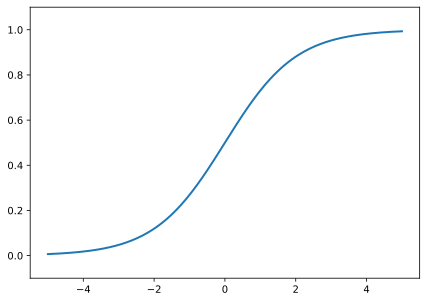

In [53]:
plot_logistic()

In [54]:
# Funkcja regresji logistcznej
def h(theta, X):
    return 1.0/(1.0 + np.exp(-X * theta))

In [55]:
# Funkcja kosztu dla regresji logistycznej
def J(h, theta, X, y):
    m = len(y)
    h_val = h(theta, X)
    s1 = np.multiply(y, np.log(h_val))
    s2 = np.multiply((1 - y), np.log(1 - h_val))
    return -np.sum(s1 + s2, axis=0) / m

In [56]:
# Gradient dla regresji logistycznej
def dJ(h, theta, X, y):
    return 1.0 / len(y) * (X.T * (h(theta, X) - y))

In [57]:
# Metoda gradientu prostego dla regresji logistycznej
def GD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, maxSteps=10000):
    errorCurr = fJ(h, theta, X, y)
    errors = [[errorCurr, theta]]
    while True:
        # oblicz nowe theta
        theta = theta - alpha * fdJ(h, theta, X, y)
        # raportuj poziom błędu
        errorCurr, errorPrev = fJ(h, theta, X, y), errorCurr
        # kryteria stopu
        if abs(errorPrev - errorCurr) <= eps:
            break
        if len(errors) > maxSteps:
            break
        errors.append([errorCurr, theta]) 
    return theta, errors

**TO DO WYRZUCENIA NIZEJ CHYBA**

In [62]:
thetaStartMx = np.matrix([0, 0]).reshape(2, 1) #TO KONKRETNIE DO WYRZUCENIA

In [61]:
# Uruchomienie metody gradientu prostego dla regresji logistycznej
thetaBest, errors = GD(h, J, dJ, thetaStartMx, XMx4, yMx4, 
                       alpha=0.1, eps=10**-7, maxSteps=1000)
print("error =", errors[-1][0])
print("theta =", thetaBest)

ValueError: shapes (1615,5) and (2,1) not aligned: 5 (dim 1) != 2 (dim 0)